In [1]:
experiment_name = 'Patients with ICD code 99591'

In [2]:
import json
import os
import random
import sys
import warnings

warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandas.io.sql as psql
import psycopg2 as pg
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_validate, GridSearchCV, train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from tqdm.auto import tqdm, trange

from nfold_roc_auc import plot_roc_auc

%matplotlib inline
random.seed(42)
np.random.seed(42)
os.environ['PYTHONHASHSEED'] = "42"
connection = pg.connect("host=localhost dbname=MIMIC-III user=postgres password=1027")


In [3]:
queries = json.load(open("queries.json"))
queries


{'patients': "SELECT subject_id, hadm_id\nFROM diagnoses_icd\nWHERE icd9_code IN ('0380', '03810', '03811', '03812', '03819', '0382', '0383', '03840', '03841', '03842', '03843', '03844', '03849', '78552', '99591', '99592')",
 'age': 'SELECT subject_id, hadm_id, AGE(admittime, dob) AS age\nFROM admissions JOIN patients USING (subject_id)',
 'admission_marital': 'SELECT subject_id, hadm_id, admission_type, marital_status FROM admissions',
 'icu_department_icusty_id': 'SELECT subject_id, hadm_id, icustay_id FROM icustays',
 'comorbidities': "SELECT subject_id, hadm_id, icd9_code\nFROM diagnoses_icd\nWHERE (subject_id) in (\n\tSELECT DISTINCT subject_id\n\tFROM diagnoses_icd\n\tWHERE icd9_code = '99591'\n)\nAND icd9_code NOT IN ('99591', '0380', '03810', '03811', '03812', '03819', '0382', '0383', '03840', '03841', '03842', '03843', '03844', '03849', '78552', '99592')",
 'systolic_bp': "select subject_id, hadm_id, avg(valuenum) as systolic\nfrom c join d_items using (itemid)\nwhere itemid i

In [4]:
patients = psql.read_sql("SELECT subject_id, hadm_id\nFROM diagnoses_icd\nWHERE icd9_code IN ('99591')", connection)
patients

,subject_id,hadm_id
0,15900,148366
1,14579,168345
2,16488,186819
3,16894,122090
4,16895,102174
...,...,...
1267,15026,146621
1268,14520,136081
1269,14467,170868
1270,14398,117257


In [5]:
df = patients.sort_values(by=['subject_id', 'hadm_id'])
df = df.groupby('subject_id').last().reset_index()
df = df.merge(pd.read_csv('patients.csv').drop('subject_id', axis=1), on='hadm_id', how='left')
df

,subject_id,hadm_id,gender,age,admission_type,marital_status,icustay_id,icd9_code,systolic,diastolic,...,lactate,calcium,anion gap,los,admittime,deathtime,delta_deathtime,mortality_30,mortality_60,mortality_90
0,61,189535,0.0,55.167032,1.0,2,217135.0,99685,NaN,NaN,...,NaN,8.500000,11.0,2.0091,2119-01-04 18:12:00,2119-02-03 01:35:00,29 days 07:23:00,1.0,1.0,1.0
1,62,116009,0.0,68.711877,1.0,2,216609.0,7140,97.545455,56.909091,...,2.100000,7.833333,10.0,2.8257,2113-02-15 00:19:00,NaN,NaN,0.0,0.0,0.0
2,64,172056,1.0,26.656789,1.0,1,232593.0,7895,109.444444,57.388889,...,NaN,NaN,10.5,2.3250,2143-03-03 09:25:00,NaN,NaN,0.0,0.0,0.0
3,85,112077,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,105,161160,1.0,35.311995,1.0,1,294980.0,7906,99.384615,60.807692,...,1.200000,8.100000,14.0,4.9968,2189-01-28 16:57:00,NaN,NaN,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1193,99383,176477,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1194,99384,153102,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1195,99461,193894,1.0,87.733972,1.0,5,267848.0,V452,131.640000,67.320000,...,1.300000,8.250000,12.5,4.8902,2157-12-30 20:00:00,NaN,NaN,0.0,0.0,0.0
1196,99503,138404,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
XY = df[['age', 'asparate aminotransferase', 'mcv', 'alanine aminotransferase', 'urea nitrogen', 'partial prothrombin time', 'prothrombin time', 'rcv', 'lactate', 'albumin', 'total bilirubin', 'mortality_30', 'mortality_60', 'mortality_90']]
XY

,age,asparate aminotransferase,mcv,alanine aminotransferase,urea nitrogen,partial prothrombin time,prothrombin time,rcv,lactate,albumin,total bilirubin,mortality_30,mortality_60,mortality_90
0,55.167032,53.0,91.50,41.0,17.00,NaN,NaN,20.300,NaN,3.2,0.70,1.0,1.0,1.0
1,68.711877,NaN,93.75,NaN,20.25,32.00,13.6,13.575,2.100000,NaN,NaN,0.0,0.0,0.0
2,26.656789,60.0,79.00,323.0,13.50,29.70,12.9,14.200,NaN,NaN,1.70,0.0,0.0,0.0
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,35.311995,NaN,78.50,NaN,38.00,43.40,17.1,16.100,1.200000,NaN,NaN,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1193,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1194,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1195,87.733972,194.0,93.50,304.5,15.50,37.05,16.9,13.750,1.300000,2.9,2.15,0.0,0.0,0.0
1196,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
XY.isnull().sum()

age                          420
asparate aminotransferase    798
mcv                          447
alanine aminotransferase     796
urea nitrogen                445
partial prothrombin time     635
prothrombin time             622
rcv                          447
lactate                      744
albumin                      877
total bilirubin              788
mortality_30                 420
mortality_60                 420
mortality_90                 420
dtype: int64

In [8]:
XY = XY.dropna(thresh=len(XY.columns)-1)
XY.isnull().sum()

age                           0
asparate aminotransferase     1
mcv                           0
alanine aminotransferase      0
urea nitrogen                 0
partial prothrombin time      3
prothrombin time              0
rcv                           0
lactate                      83
albumin                      71
total bilirubin               0
mortality_30                  0
mortality_60                  0
mortality_90                  0
dtype: int64

In [9]:
XY.fillna(XY.mean(), inplace=True)
XY

,age,asparate aminotransferase,mcv,alanine aminotransferase,urea nitrogen,partial prothrombin time,prothrombin time,rcv,lactate,albumin,total bilirubin,mortality_30,mortality_60,mortality_90
7,51.919756,50.5,89.000000,35.500000,10.0,33.50,13.600,14.300000,2.192608,3.900000,1.000,0.0,0.0,0.0
9,52.451340,57.0,104.000000,65.000000,15.0,29.70,13.200,16.200000,2.500000,2.785489,0.300,0.0,0.0,0.0
12,49.615499,51.0,92.000000,25.000000,15.0,27.50,24.700,16.200000,1.300000,2.900000,0.200,0.0,0.0,0.0
18,71.432900,15.5,94.333333,28.500000,16.0,25.10,15.050,13.166667,2.800000,2.750000,0.600,0.0,0.0,0.0
23,83.323907,25.0,84.000000,7.000000,19.5,34.90,14.400,15.800000,3.266667,2.400000,0.400,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1184,53.915560,580.5,85.000000,844.500000,6.0,35.25,17.000,13.700000,1.200000,2.550000,5.900,0.0,0.0,0.0
1187,47.497907,85.0,117.500000,50.666667,38.0,63.00,36.275,16.600000,10.787500,2.066667,17.000,1.0,1.0,1.0
1188,37.554430,60.0,77.250000,81.333333,89.5,38.30,25.325,18.700000,2.192608,1.600000,7.875,0.0,0.0,0.0
1195,87.733972,194.0,93.500000,304.500000,15.5,37.05,16.900,13.750000,1.300000,2.900000,2.150,0.0,0.0,0.0


Text(0.5, 1.01, 'Patients with ICD code 99591')

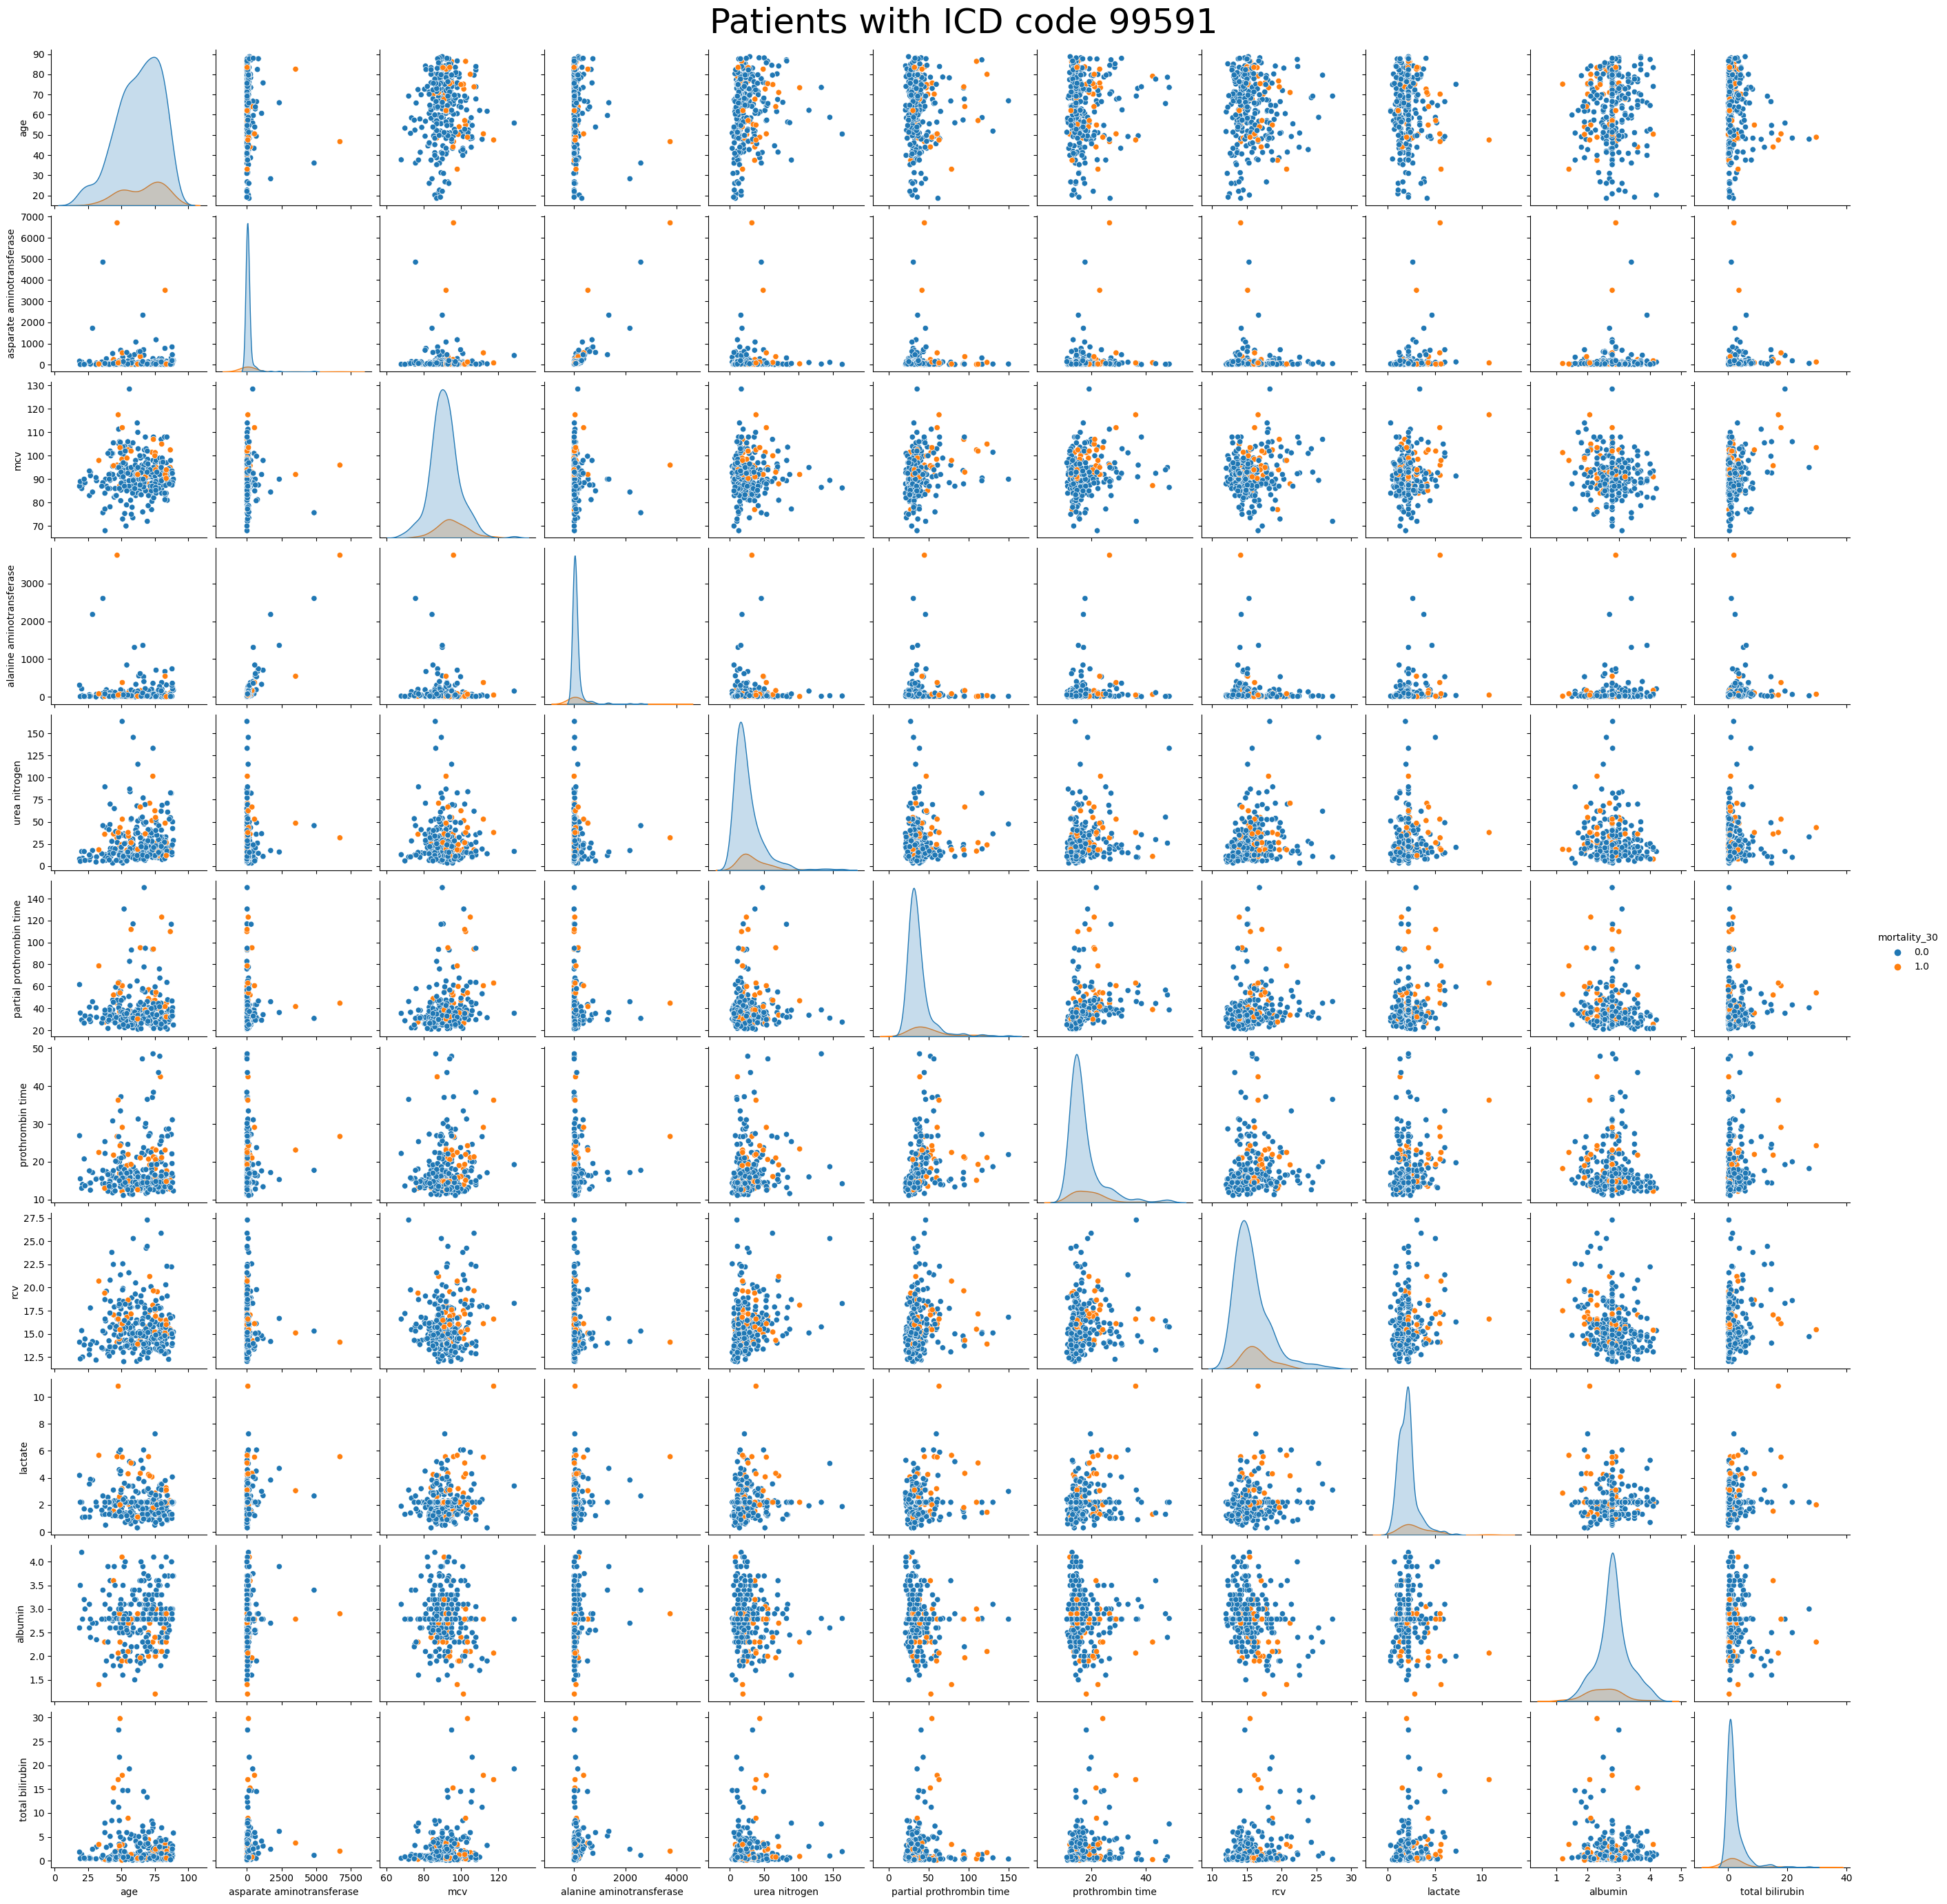

In [10]:
g = sns.pairplot(XY[XY.columns.to_list()[:-2]], hue='mortality_30')
g.fig.suptitle(experiment_name, fontsize=36, y=1.01)

In [11]:
X = XY.drop(["mortality_30", "mortality_60", "mortality_90"], axis=1)
y = XY["mortality_30"]
y_60 = XY["mortality_60"]
y_90 = XY["mortality_90"]
X

,age,asparate aminotransferase,mcv,alanine aminotransferase,urea nitrogen,partial prothrombin time,prothrombin time,rcv,lactate,albumin,total bilirubin
7,51.919756,50.5,89.000000,35.500000,10.0,33.50,13.600,14.300000,2.192608,3.900000,1.000
9,52.451340,57.0,104.000000,65.000000,15.0,29.70,13.200,16.200000,2.500000,2.785489,0.300
12,49.615499,51.0,92.000000,25.000000,15.0,27.50,24.700,16.200000,1.300000,2.900000,0.200
18,71.432900,15.5,94.333333,28.500000,16.0,25.10,15.050,13.166667,2.800000,2.750000,0.600
23,83.323907,25.0,84.000000,7.000000,19.5,34.90,14.400,15.800000,3.266667,2.400000,0.400
...,...,...,...,...,...,...,...,...,...,...,...
1184,53.915560,580.5,85.000000,844.500000,6.0,35.25,17.000,13.700000,1.200000,2.550000,5.900
1187,47.497907,85.0,117.500000,50.666667,38.0,63.00,36.275,16.600000,10.787500,2.066667,17.000
1188,37.554430,60.0,77.250000,81.333333,89.5,38.30,25.325,18.700000,2.192608,1.600000,7.875
1195,87.733972,194.0,93.500000,304.500000,15.5,37.05,16.900,13.750000,1.300000,2.900000,2.150


In [12]:
y

7       0.0
9       0.0
12      0.0
18      0.0
23      1.0
       ... 
1184    0.0
1187    1.0
1188    0.0
1195    0.0
1197    0.0
Name: mortality_30, Length: 303, dtype: float64

In [13]:
# Oversample the data
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X.values, y.values)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, stratify=y_res, test_size=0.33, random_state=42)

# Scale the data
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [14]:
# MLP
mlp = MLPClassifier(hidden_layer_sizes=(5), random_state=42)
mlp.fit(X_train, y_train)

predictions = mlp.predict(X_test)

print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))


[[74 14]
 [25 62]]
              precision    recall  f1-score   support

         0.0       0.75      0.84      0.79        88
         1.0       0.82      0.71      0.76        87

    accuracy                           0.78       175
   macro avg       0.78      0.78      0.78       175
weighted avg       0.78      0.78      0.78       175



In [15]:
# Cross validation
cv_results = cross_validate(mlp, X_res, y_res, cv=5, scoring=['accuracy', 'f1', 'recall', 'precision'], return_train_score=True)
print('Accuracy  ', cv_results['test_accuracy'].mean(), '\t', cv_results['test_accuracy'].std())
print('F1        ', cv_results['test_f1'].mean(), '\t', cv_results['test_f1'].std())
print('Recall    ', cv_results['test_recall'].mean(), '\t', cv_results['test_recall'].std())
print('Precision ', cv_results['test_precision'].mean(), '\t', cv_results['test_precision'].std())
cv_results

Accuracy   0.6075471698113207 	 0.044888216050454025
F1         0.6258110407027871 	 0.049152179223110916
Recall     0.660377358490566 	 0.07915538476755865
Precision  0.5983133092486541 	 0.043400356239969004


{'fit_time': array([0.15599942, 0.1570015 , 0.15399909, 0.15699983, 0.1430006 ]),
 'score_time': array([0.00300288, 0.00199771, 0.00300002, 0.00200105, 0.00299859]),
 'test_accuracy': array([0.66037736, 0.6509434 , 0.56603774, 0.61320755, 0.54716981]),
 'train_accuracy': array([0.63207547, 0.61556604, 0.63443396, 0.62971698, 0.62735849]),
 'test_f1': array([0.68965517, 0.6407767 , 0.56603774, 0.66115702, 0.57142857]),
 'train_f1': array([0.66233766, 0.63205418, 0.65324385, 0.65494505, 0.64732143]),
 'test_recall': array([0.75471698, 0.62264151, 0.56603774, 0.75471698, 0.60377358]),
 'train_recall': array([0.72169811, 0.66037736, 0.68867925, 0.70283019, 0.68396226]),
 'test_precision': array([0.63492063, 0.66      , 0.56603774, 0.58823529, 0.54237288]),
 'train_precision': array([0.612     , 0.60606061, 0.6212766 , 0.61316872, 0.61440678])}

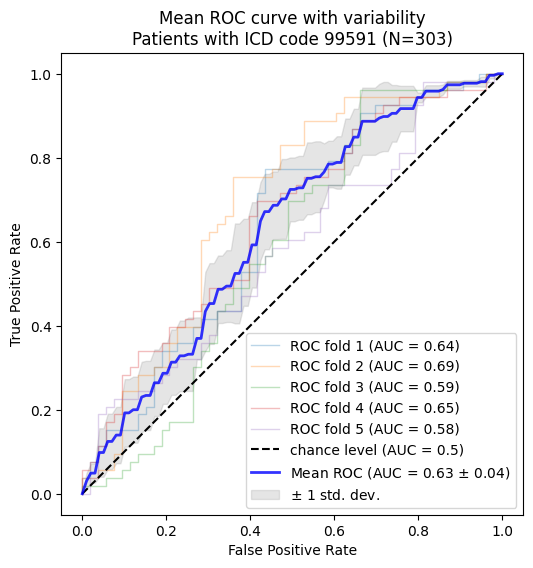

In [16]:
plot_roc_auc(mlp, X_res, y_res, experiment_name, len(XY))

In [17]:
grid = [
    {
        'activation': ['logistic', 'tanh', 'relu'],
        'alpha': [0.0001, 0.0005, 0.001, 0.005],
        'learning_rate_init': [0.0005, 0.001, 0.005, 0.01],
        'hidden_layer_sizes': [(5), (10), (20), (5, 5), (10, 10), (20, 20)]
     }
]

grid_search = GridSearchCV(estimator=MLPClassifier(random_state=42), param_grid=grid, cv=5, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

grid_search.best_params_


Fitting 5 folds for each of 288 candidates, totalling 1440 fits


{'activation': 'relu',
 'alpha': 0.0001,
 'hidden_layer_sizes': (20, 20),
 'learning_rate_init': 0.01}

In [18]:
# fine-tuned MLP
mlp = MLPClassifier(
    hidden_layer_sizes=grid_search.best_params_["hidden_layer_sizes"],
    random_state=42,
    activation=grid_search.best_params_["activation"],
    alpha=grid_search.best_params_["alpha"],
    learning_rate_init=grid_search.best_params_["learning_rate_init"],
)
mlp.fit(X_train, y_train)

predictions = mlp.predict(X_test)

print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))


[[84  4]
 [ 9 78]]
              precision    recall  f1-score   support

         0.0       0.90      0.95      0.93        88
         1.0       0.95      0.90      0.92        87

    accuracy                           0.93       175
   macro avg       0.93      0.93      0.93       175
weighted avg       0.93      0.93      0.93       175



In [19]:
# Cross validation
cv_results = cross_validate(mlp, X_res, y_res, cv=5, scoring=['accuracy', 'f1', 'recall', 'precision'], return_train_score=True)
print('Accuracy  ', cv_results['test_accuracy'].mean(), '\t', cv_results['test_accuracy'].std())
print('F1        ', cv_results['test_f1'].mean(), '\t', cv_results['test_f1'].std())
print('Recall    ', cv_results['test_recall'].mean(), '\t', cv_results['test_recall'].std())
print('Precision ', cv_results['test_precision'].mean(), '\t', cv_results['test_precision'].std())
cv_results

Accuracy   0.6641509433962265 	 0.05487939461226031
F1         0.6416895534287514 	 0.14569535067088574
Recall     0.679245283018868 	 0.24716260971792928
Precision  0.6964122125322486 	 0.0896460877820827


{'fit_time': array([0.03799939, 0.10299611, 0.06499767, 0.05900073, 0.04399991]),
 'score_time': array([0.00200033, 0.00300288, 0.00300145, 0.00299978, 0.00200105]),
 'test_accuracy': array([0.69811321, 0.72641509, 0.69811321, 0.58490566, 0.61320755]),
 'train_accuracy': array([0.70754717, 0.69339623, 0.73820755, 0.63679245, 0.62971698]),
 'test_f1': array([0.73333333, 0.68817204, 0.73770492, 0.35294118, 0.6962963 ]),
 'train_f1': array([0.73275862, 0.61988304, 0.74829932, 0.51265823, 0.71914132]),
 'test_recall': array([0.83018868, 0.60377358, 0.8490566 , 0.22641509, 0.88679245]),
 'train_recall': array([0.80188679, 0.5       , 0.77830189, 0.38207547, 0.94811321]),
 'test_precision': array([0.65671642, 0.8       , 0.65217391, 0.8       , 0.57317073]),
 'train_precision': array([0.67460317, 0.81538462, 0.72052402, 0.77884615, 0.57925072])}

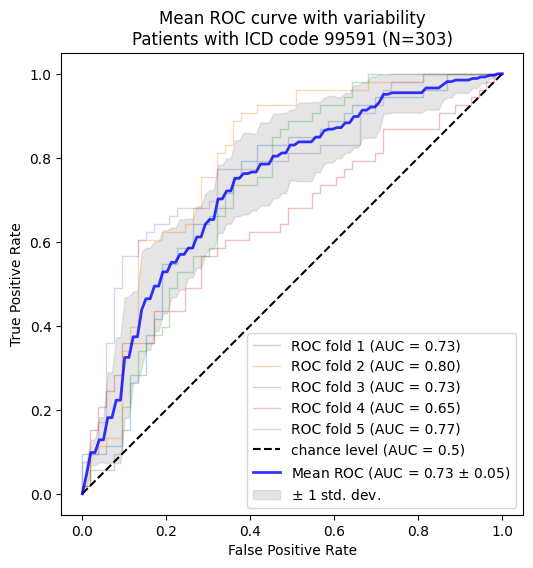

In [20]:
plot_roc_auc(mlp, X_res, y_res, experiment_name, len(XY))

In [21]:
# Oversample the data
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X.values, y_60.values)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, stratify=y_res, test_size=0.33, random_state=42)

# Scale the data
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

grid_search = GridSearchCV(estimator=MLPClassifier(random_state=42), param_grid=grid, cv=5, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

print('best params', grid_search.best_params_)

mlp = MLPClassifier(
    hidden_layer_sizes=grid_search.best_params_["hidden_layer_sizes"],
    random_state=42,
    activation=grid_search.best_params_["activation"],
    alpha=grid_search.best_params_["alpha"],
    learning_rate_init=grid_search.best_params_["learning_rate_init"],
)

# MLP
mlp = MLPClassifier(hidden_layer_sizes=(5), random_state=42)
mlp.fit(X_train, y_train)

predictions = mlp.predict(X_test)

print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))


Fitting 5 folds for each of 288 candidates, totalling 1440 fits
best params {'activation': 'relu', 'alpha': 0.0005, 'hidden_layer_sizes': (20, 20), 'learning_rate_init': 0.005}
[[59 27]
 [21 64]]
              precision    recall  f1-score   support

         0.0       0.74      0.69      0.71        86
         1.0       0.70      0.75      0.73        85

    accuracy                           0.72       171
   macro avg       0.72      0.72      0.72       171
weighted avg       0.72      0.72      0.72       171



In [22]:
# Cross validation
cv_results = cross_validate(mlp, X_res, y_res, cv=5, scoring=['accuracy', 'f1', 'recall', 'precision'], return_train_score=True)
print('Accuracy  ', cv_results['test_accuracy'].mean(), '\t', cv_results['test_accuracy'].std())
print('F1        ', cv_results['test_f1'].mean(), '\t', cv_results['test_f1'].std())
print('Recall    ', cv_results['test_recall'].mean(), '\t', cv_results['test_recall'].std())
print('Precision ', cv_results['test_precision'].mean(), '\t', cv_results['test_precision'].std())
cv_results

Accuracy   0.5693427931292009 	 0.05454550995061227
F1         0.5807237755196784 	 0.06440193830877008
Recall     0.6019607843137254 	 0.09007966528639935
Precision  0.5633089210526977 	 0.047105812836023726


{'fit_time': array([0.19599795, 0.17400002, 0.15600014, 0.15699601, 0.1579988 ]),
 'score_time': array([0.00299907, 0.00399995, 0.00300193, 0.00400066, 0.00199914]),
 'test_accuracy': array([0.54807692, 0.67307692, 0.56730769, 0.51456311, 0.54368932]),
 'train_accuracy': array([0.60869565, 0.5531401 , 0.57971014, 0.59759036, 0.58795181]),
 'test_f1': array([0.53465347, 0.69642857, 0.57142857, 0.50980392, 0.59130435]),
 'train_f1': array([0.59090909, 0.58049887, 0.58571429, 0.59952038, 0.58190709]),
 'test_recall': array([0.51923077, 0.75      , 0.57692308, 0.50980392, 0.65384615]),
 'train_recall': array([0.56521739, 0.61835749, 0.5942029 , 0.60096154, 0.57487923]),
 'test_precision': array([0.55102041, 0.65      , 0.56603774, 0.50980392, 0.53968254]),
 'train_precision': array([0.61904762, 0.54700855, 0.57746479, 0.59808612, 0.58910891])}

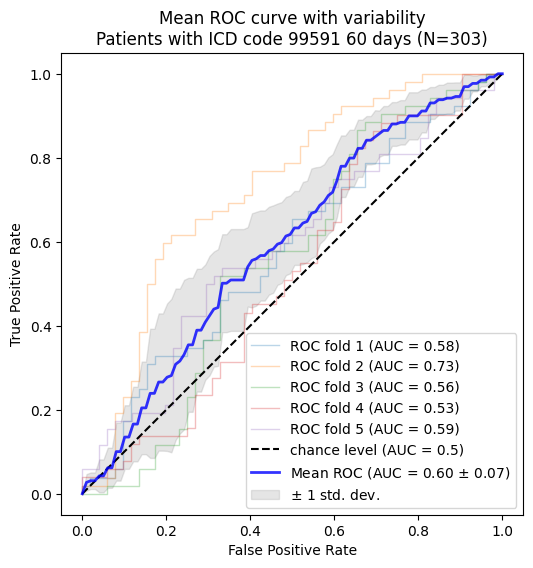

In [23]:
plot_roc_auc(mlp, X_res, y_res, experiment_name + ' 60 days', len(XY))